## Neural Network using Tensorflow

This exercise is adapted from https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/

Now you have successfully used SciKit Learn's MLP to work on the built-in Breast Cancer Data Set, let's try another one!

Download the wine dataset from UCI Machine learning repository (http://archive.ics.uci.edu/ml/datasets/Wine/). Import the dataset into a pandas dataframe

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the data

Let's download the data and load it into a Pandas dataframe:

In [2]:
import pandas as pd
dataframe = pd.read_csv('./Data/Wine.csv')

Check out the dataframe - what are the first few rows of data?

In [3]:
# find out the attributes in the dataset
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Customer_Segment      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
# find out the total instances and number of features
dataframe.shape

(178, 14)

In [5]:
# use describe to find out more about the data
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic_Acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Ash_Alcanity,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_Phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_Phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_Intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [6]:
dataframe.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


Let's split the data into a training and validation set:

In [7]:
val_dataframe = dataframe.sample(frac=0.2, random_state=4321)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 142 samples for training and 36 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:

In [8]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Customer_Segment")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

In [9]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Alcohol': <tf.Tensor: shape=(), dtype=float64, numpy=13.74>, 'Malic_Acid': <tf.Tensor: shape=(), dtype=float64, numpy=1.67>, 'Ash': <tf.Tensor: shape=(), dtype=float64, numpy=2.25>, 'Ash_Alcanity': <tf.Tensor: shape=(), dtype=float64, numpy=16.4>, 'Magnesium': <tf.Tensor: shape=(), dtype=int64, numpy=118>, 'Total_Phenols': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>, 'Flavanoids': <tf.Tensor: shape=(), dtype=float64, numpy=2.9>, 'Nonflavanoid_Phenols': <tf.Tensor: shape=(), dtype=float64, numpy=0.21>, 'Proanthocyanins': <tf.Tensor: shape=(), dtype=float64, numpy=1.62>, 'Color_Intensity': <tf.Tensor: shape=(), dtype=float64, numpy=5.85>, 'Hue': <tf.Tensor: shape=(), dtype=float64, numpy=0.92>, 'OD280': <tf.Tensor: shape=(), dtype=float64, numpy=3.2>, 'Proline': <tf.Tensor: shape=(), dtype=int64, numpy=1060>}
Target: tf.Tensor(1, shape=(), dtype=int64)


Let's batch the datasets:

In [10]:
train_ds = train_ds.batch(18)
val_ds = val_ds.batch(18)

## Feature preprocessing with Keras layers

In [11]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

With this done, we can create our end-to-end model:

In [12]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic_Acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Ash_Alcanity,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_Phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_Phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_Intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [19]:
# Numerical features
Alcohol = keras.Input(shape=(1,), name="Alcohol")
Malic_Acid = keras.Input(shape=(1,), name="Malic_Acid")
Ash = keras.Input(shape=(1,), name="Ash")
Ash_Alcanity = keras.Input(shape=(1,), name="Ash_Alcanity")
Magnesium = keras.Input(shape=(1,), name="Magnesium")
Total_Phenols = keras.Input(shape=(1,), name="Total_Phenols")
Flavanoids = keras.Input(shape=(1,), name="Flavanoids")
Nonflavanoid_Phenols = keras.Input(shape=(1,), name="Nonflavanoid_Phenols")
Proanthocyanins = keras.Input(shape=(1,), name="Proanthocyanins")
Color_Intensity = keras.Input(shape=(1,), name="Color_Intensity")
Hue = keras.Input(shape=(1,), name="Hue")
OD280 = keras.Input(shape=(1,), name="OD280")
Proline = keras.Input(shape=(1,), name="Proline")

all_inputs = [
    Alcohol,
    Malic_Acid,
    Ash,
    Ash_Alcanity,
    Magnesium,
    Total_Phenols,
    Flavanoids,
    Nonflavanoid_Phenols,
    Proanthocyanins,
    Color_Intensity,
    Hue,
    OD280,
    Proline,
]

# Numerical features
Alcohol_encoded = encode_numerical_feature(Alcohol, "Alcohol", train_ds)
Malic_Acid_encoded = encode_numerical_feature(Malic_Acid, "Malic_Acid", train_ds)
Ash_encoded = encode_numerical_feature(Ash, "Ash", train_ds)
Ash_Alcanity_encoded = encode_numerical_feature(Ash_Alcanity, "Ash_Alcanity", train_ds)
Magnesium_encoded = encode_numerical_feature(Magnesium, "Magnesium", train_ds)
Total_Phenols_encoded = encode_numerical_feature(Total_Phenols, "Total_Phenols", train_ds)
Flavanoids_encoded = encode_numerical_feature(Flavanoids, "Flavanoids", train_ds)
Nonflavanoid_Phenols_encoded = encode_numerical_feature(Nonflavanoid_Phenols, "Nonflavanoid_Phenols", train_ds)
Proanthocyanins_encoded = encode_numerical_feature(Proanthocyanins, "Proanthocyanins", train_ds)
Color_Intensity_encoded = encode_numerical_feature(Color_Intensity, "Color_Intensity", train_ds)
Hue_encoded = encode_numerical_feature(Hue, "Hue", train_ds)
OD280_encoded = encode_numerical_feature(OD280, "OD280", train_ds)
Proline_encoded = encode_numerical_feature(Proline, "Proline", train_ds)

all_features = layers.concatenate(
    [
        Alcohol_encoded,
        Malic_Acid_encoded,
        Ash_encoded,
        Ash_Alcanity_encoded,
        Magnesium_encoded,
        Total_Phenols_encoded,
        Flavanoids_encoded,
        Nonflavanoid_Phenols_encoded,
        Proanthocyanins_encoded,
        Color_Intensity_encoded,
        Hue_encoded,
        OD280_encoded,
        Proline_encoded,
    ]
)
x = layers.Dense(13, activation="relu")(all_features)
x = layers.Dense(13, activation="relu")(x)
#x = layers.Dropout(0.5)(x)

# Softmax has a higher accuracy
output = layers.Dense(4, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "b", metrics=["accuracy"])

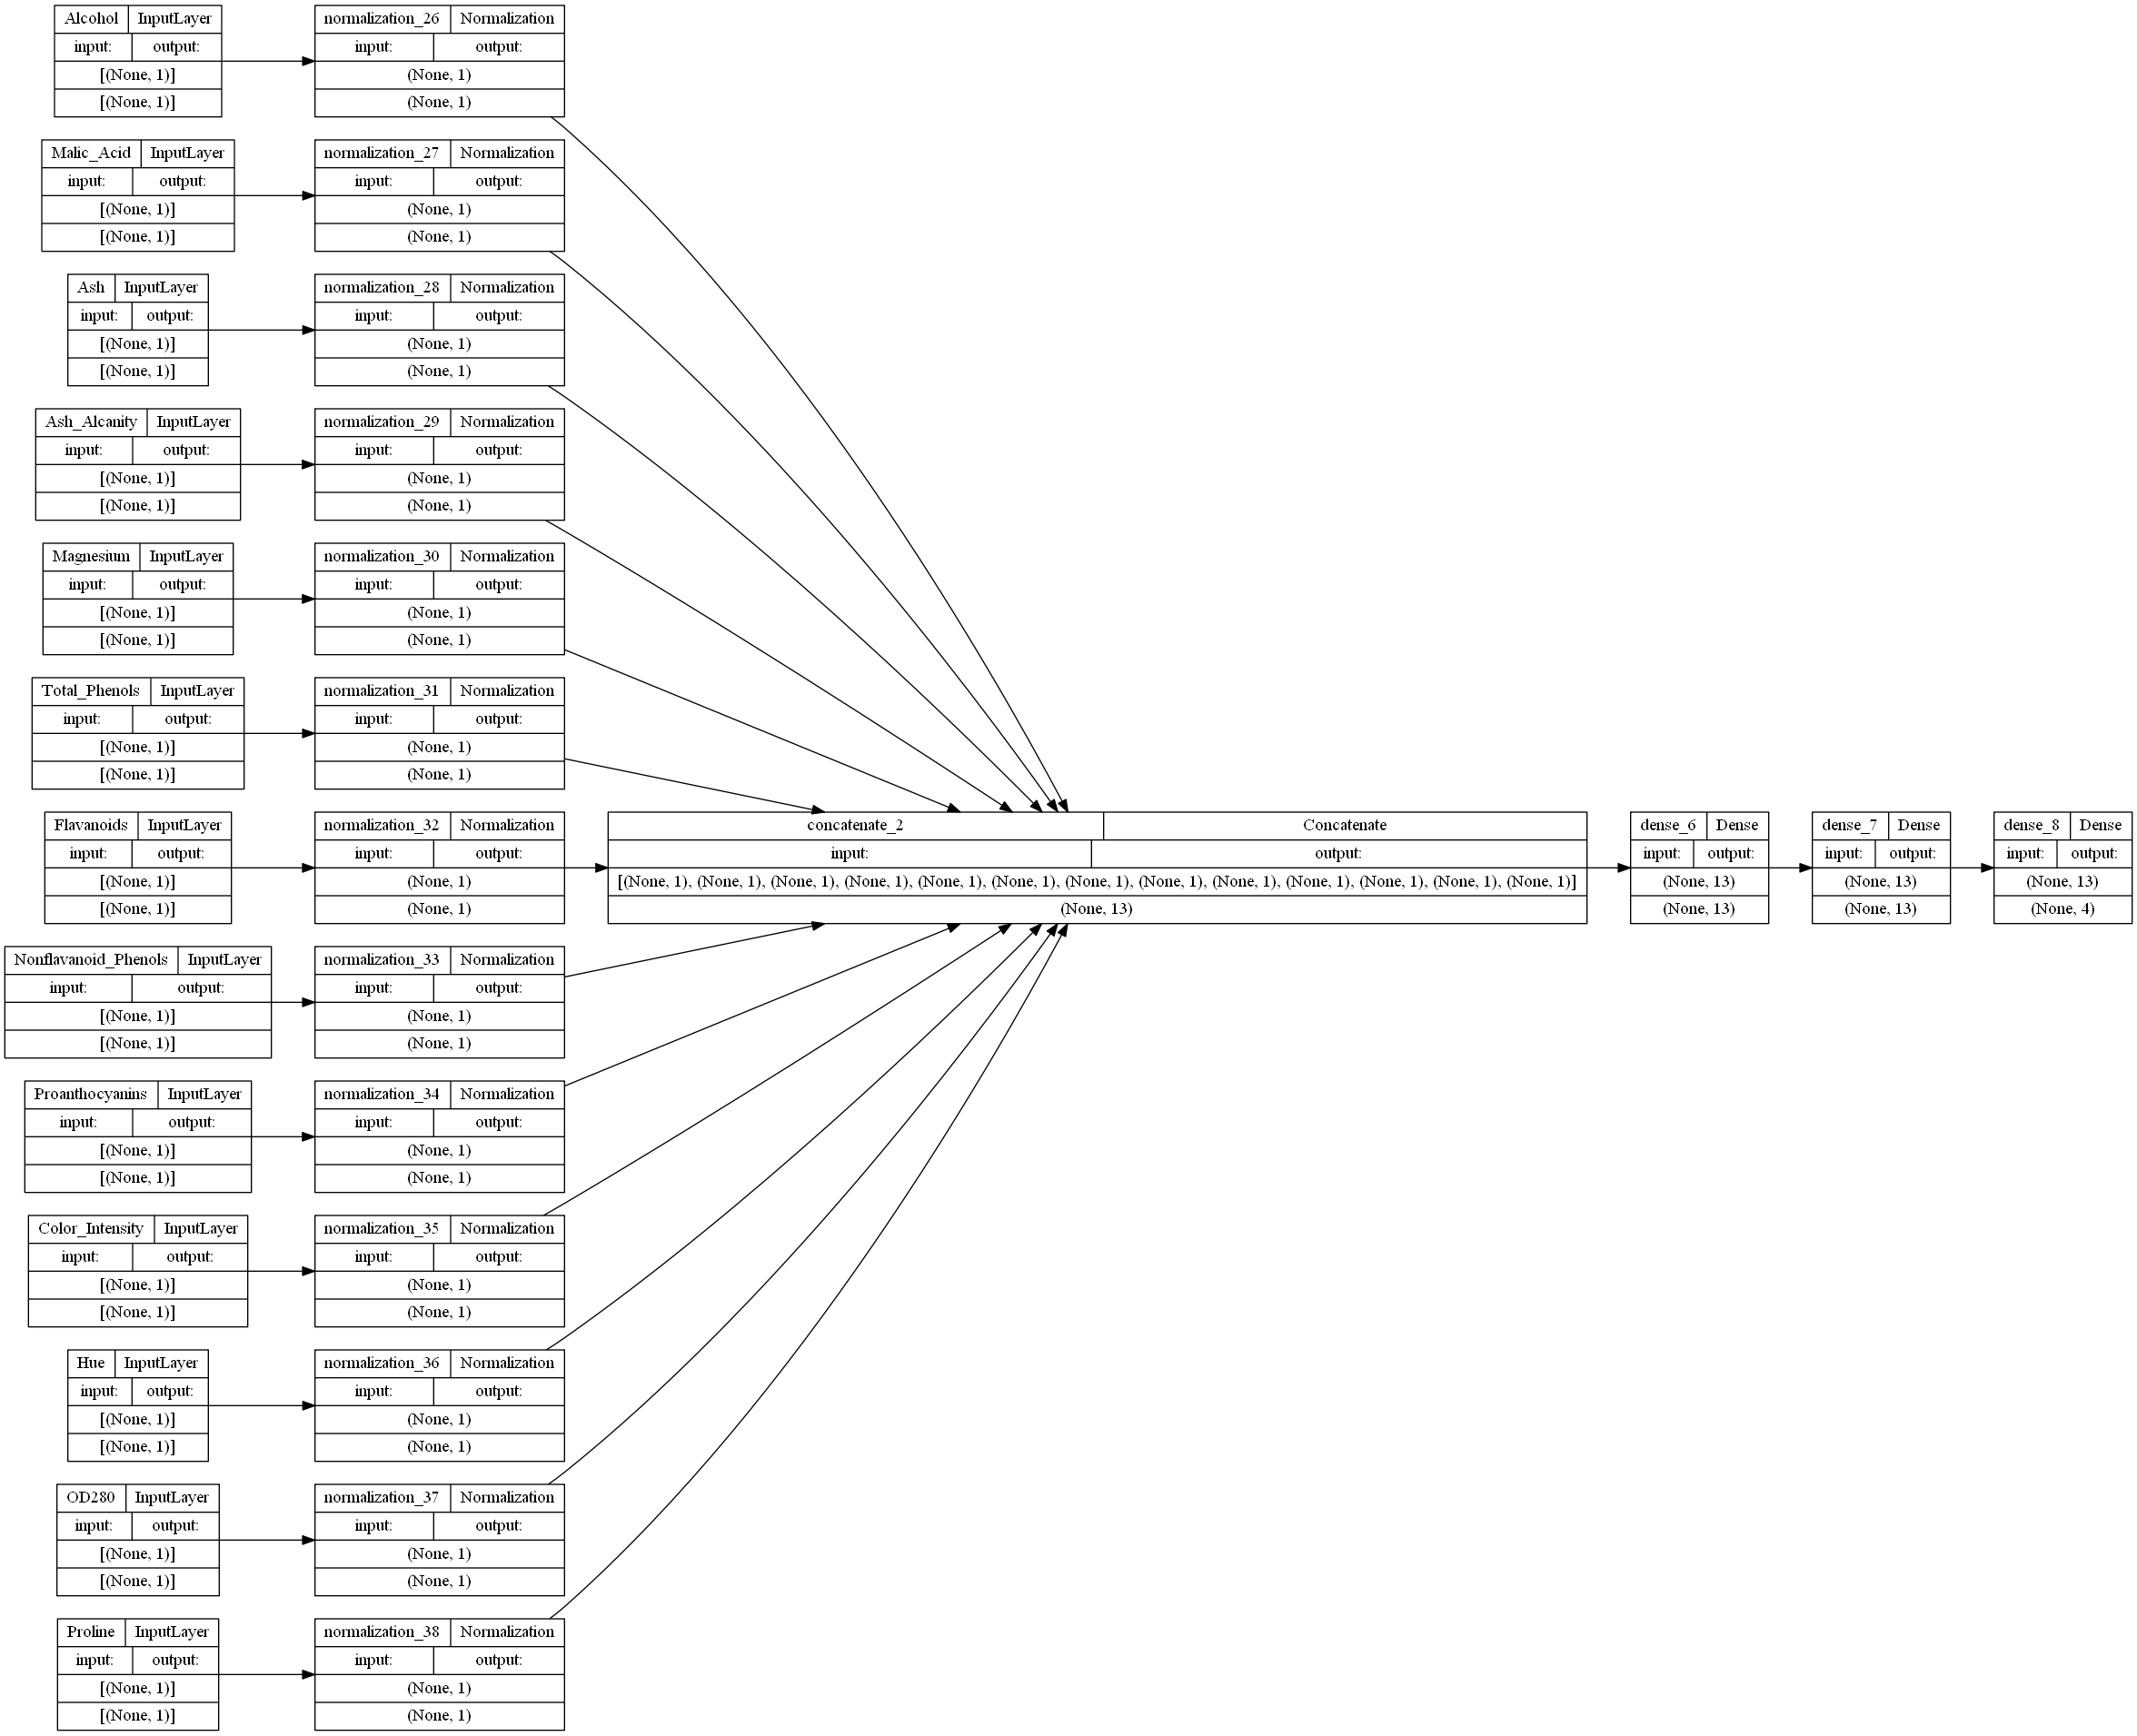

In [20]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Training the model

In [21]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 1s 66ms/step - loss: 1.6118 - accuracy: 0.0775 - val_loss: 1.4373 - val_accuracy: 0.2222
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 1.4773 - accuracy: 0.1408 - val_loss: 1.3578 - val_accuracy: 0.2778
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 1.3693 - accuracy: 0.2958 - val_loss: 1.2891 - val_accuracy: 0.3889
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 1.2807 - accuracy: 0.3662 - val_loss: 1.2264 - val_accuracy: 0.5833
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 1.2089 - accuracy: 0.4930 - val_loss: 1.1703 - val_accuracy: 0.6389
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 1.1403 - accuracy: 0.5845 - val_loss: 1.1155 - val_accuracy: 0.6667
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 1.0790 - accuracy: 0.6620 - val_loss: 1.0580 - val_accuracy: 0.7500
Epoch 8/50
8/8 [============

## Others

In [23]:
test = dataframe.head(1)
test

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,1


In [24]:
test.drop('Customer_Segment')

KeyError: "['Customer_Segment'] not found in axis"

In [ ]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}